In [0]:
import numpy as  np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim

In [0]:
class DiffLayer(nn.Module):
  def __init__(self, din, dout, g, g_ ):
    super().__init__()
    self.din = din
    self.dout = dout

    # パラメータ
    self.W = nn.Parameter( torch.randn( (din,dout) ) )
    self.b = nn.Parameter( torch.randn( [dout,1] ) )

    #　活性化関数とその導関数
    self.g = g
    self.g_ = g_

  def forward(self, input):
    h1 = input[0]
    h1_ = input[1]

    # 全結合相で関数の出力を計算
    a = torch.matmul( torch.t(self.W), h1 ) + self.b
    h2 = self.g( a )

    # 微分を計算
    h2_ = torch.matmul( self.W, torch.diag_embed( self.g_(a).reshape(-1,self.dout) ) )
    h2_ = torch.matmul( h1_, h2_ )
    
    return h2, h2_


In [0]:
class DiffNet(nn.Module):
  def __init__(self, device="cpu"):
    super().__init__()

    self.device = device

    # シグモイド関数とその導関数
    sig = nn.Sigmoid()
    sig_ = lambda x: (1 - sig(x))*sig(x)

    # 恒等写像とその導関数
    identity = lambda x: x
    identity_ = lambda x: torch.ones( x.shape ).to("cuda")

    # ネットワーク構築
    self.dl1 = DiffLayer(2, 3, sig, sig_)
    self.dl2 = DiffLayer(3, 2, sig, sig_)
    self.dl3 = DiffLayer(2, 1, identity, identity_)

    # 再帰的に計算するための初期値
    self.h0_ = torch.eye(self.dl1.din).to(self.device)

  def forward(self, x):
    x = self.dl1( [x, self.h0_] )
    x = self.dl2( x )
    x = self.dl3( x )

    return x

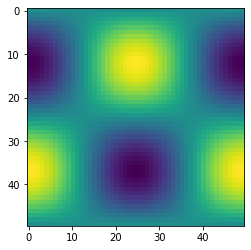

In [10]:
# 学習データ
def f(x, y):
  return -np.cos(x) * np.sin(y)

def f_x(x, y):
  return np.sin(x) * np.sin(y)

def f_y(x, y):
  return -np.cos(x) * np.cos(y)

size = 50
train_xy =[]
train_f = []
train_f_ = []
img = np.zeros( (size,size) )

for y in np.linspace(-np.pi, np.pi, size):
  for x in np.linspace(-np.pi, np.pi, size):
    train_xy.append( (x,y) )
    train_f.append( f(x,y) )
    train_f_.append( (f_x(x,y), f_y(x,y)) )

train_xy = torch.Tensor( train_xy ).reshape( size*size, 2, 1 )
train_f = torch.Tensor( train_f ).reshape( size*size, 1, 1 )
train_f_ = torch.Tensor( train_f_ ).reshape( size*size, 2, 1 )

plt.imshow( train_f.reshape( size, size ) )

In [27]:
device = "cuda"

model = DiffNet( device )

model.to( device )
train_xy = train_xy.to(device)
train_f = train_f.to( device )
train_f_ = train_f_.to( device )

optimizer = optim.Adam( model.parameters(), lr=0.01 )
calc_loss = nn.MSELoss()
losses = []

for it in range(5000):
  f, f_ = model( train_xy )

  loss1 = calc_loss( f, train_f )
  loss2 = calc_loss( f_, train_f_ )
  loss = loss1+loss2

  losses.append( (loss1, loss2) )

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  if it%500==0:
    print(loss1, loss2)

f = f.detach().cpu().numpy()
f_ = f_.detach().cpu().numpy()
losses = torch.Tensor( losses ).detach().cpu().numpy()

tensor(0.4981, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.2590, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0381, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0791, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0164, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0555, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0141, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0502, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0125, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0451, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0115, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0417, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0106, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0388, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0098, device='cuda:0', grad_fn=<MseLossBackward>) tensor(0.0361, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0091, device='cuda:0', grad_fn=<MseLossBackward

f(x,y)


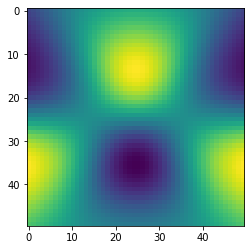

f_x(x, y)


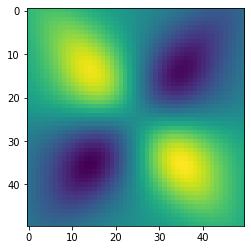

f_y(x, y)


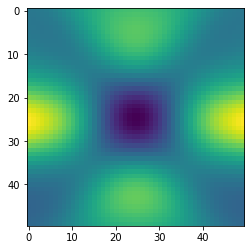

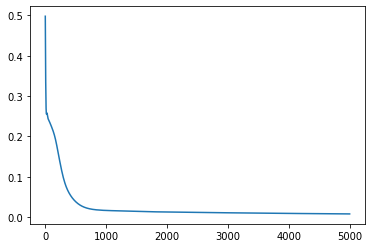

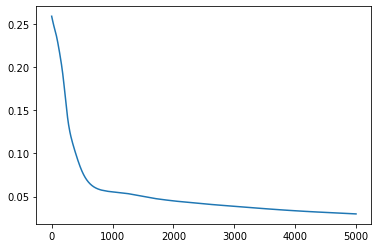

In [28]:
print("f(x,y)")
plt.imshow( f.reshape(size, size) )
plt.show()

print("f_x(x, y)")
plt.imshow( f_.reshape(size, size, 2)[:,:,0] )
plt.show()

print( "f_y(x, y)" )
plt.imshow( f_.reshape(size, size, 2)[:,:,1] )
plt.show()

plt.plot( range(len(losses)), losses[:,0] )
plt.show()

plt.plot( range(len(losses)), losses[:,1] )
plt.show()